In [32]:
import pandas as pd
import numpy as np
import time
import multiprocessing as mp
from dask.dataframe import from_pandas
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 100)

# 1. BeforeModel

## 1.1 Pandas 

In [33]:
# read data
data = pd.read_csv('onlinefraud.csv')
data = data.drop(['isFlaggedFraud','nameOrig','nameDest','step'],axis=1)

# feature engineering
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown = "ignore",sparse_output=False)
type_enc = enc.fit_transform(data['type'].values.reshape(-1, 1))
data = pd.concat([data,pd.DataFrame(type_enc)],axis=1)
data.rename(columns={0:'type_CASH_IN',1:'type_CASH_OUT',2:'type_DEBIT',3:'type_PAYMENT',4:'type_TRANSFER'},inplace=True)
data = data.drop('type',axis=1)
data['orig_balance_diff'] = data.oldbalanceOrg - data.newbalanceOrig
data['dest_balance_diff'] = data.oldbalanceDest - data.newbalanceDest
data = data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
data = data.drop(['type_PAYMENT','type_CASH_IN','type_DEBIT'],axis=1)

# Handling unbalanced data
IsNotFraud_count,IsFraud_count = data['isFraud'].value_counts()
IsNotFraud = data[data['isFraud'] == 0]
IsFraud = data[data['isFraud'] == 1]
IsFraud_over = IsFraud.sample(IsNotFraud_count,replace=True)
over_balanced_data = pd.concat([IsNotFraud,IsFraud_over], axis=0)
IsNotFraud_count,IsFraud_count = data['isFraud'].value_counts()
IsNotFraud = data[data['isFraud'] == 0]
IsFraud = data[data['isFraud'] == 1]
IsNotFraud_under = IsNotFraud.sample(frac=0.001)
under_balanced_data = pd.concat([IsNotFraud_under,IsFraud], axis=0)

## 1.2 Dask

In [34]:
# pip install "dask[distributed]"

In [35]:
# read data
data_dd = pd.read_csv('onlinefraud.csv')
data_dd = data_dd.drop(['isFlaggedFraud','nameOrig','nameDest','step'],axis=1)
data_dd = from_pandas(data_dd, npartitions = 16)

# feature engineering
from dask_ml.preprocessing import DummyEncoder
encoder = DummyEncoder()  
data_dd = data_dd.categorize(['type'])
data_dd = encoder.fit_transform(data_dd)
data_dd['orig_balance_diff'] = data_dd.oldbalanceOrg - data_dd.newbalanceOrig
data_dd['dest_balance_diff'] = data_dd.oldbalanceDest - data_dd.newbalanceDest
data_dd = data_dd.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)
data_dd = data_dd.drop(['type_PAYMENT','type_CASH_IN','type_DEBIT'],axis=1)

# Handling unbalanced data
IsNotFraud_count,IsFraud_count = data_dd['isFraud'].value_counts()
IsNotFraud = data_dd[data_dd['isFraud'] == 0]
IsFraud = data_dd[data_dd['isFraud'] == 1]
IsFraud_over = IsFraud.sample(frac = 773.7,replace=True)
over_balanced_data_dd = dd.concat([IsNotFraud,IsFraud_over], axis=0)
IsFraud_count, IsNotFraud_count = data_dd['isFraud'].value_counts()
IsNotFraud = data_dd[data_dd['isFraud'] == 0]
IsFraud = data_dd[data_dd['isFraud'] == 1]
IsNotFraud_under = IsNotFraud.sample(frac=0.001)
under_balanced_data_dd = dd.concat([IsNotFraud_under,IsFraud], axis=0)

# 2. Results Evaluation

## 2.1 Pandas 

### 2.1.1 Model evaluation metrics

In [36]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 1 CPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 1 CPU(pandas): 

accuracy  0.9810529148468996
precision 0.9661844948851297
recall    0.9970380106248006
f1        0.9813688096720169


In [37]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 2 CPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 2 CPU(pandas): 

accuracy  0.9810505542806311
precision 0.9661800788727759
recall    0.9970380106248006
f1        0.9813665317144222


In [38]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.8,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 4 CPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 4 CPU(pandas): 

accuracy  0.9810509477083426
precision 0.9661808148720316
recall    0.9970380106248006
f1        0.9813669113732869


In [39]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.8,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 8 CPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 8 CPU(pandas): 

accuracy  0.981053308274611
precision 0.9661852308911132
recall    0.9970380106248006
f1        0.9813691893326442


In [40]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 1 GPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 1 GPU(pandas): 

accuracy  0.9810517345637654
precision 0.9661822868739068
recall    0.9970380106248006
f1        0.9813676706918977


In [41]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 2 GPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 2 GPU(pandas): 

accuracy  0.9810505542806311
precision 0.9661800788727759
recall    0.9970380106248006
f1        0.9813665317144222


In [42]:
# Remodel predictions using optimal parameters
from sklearn.model_selection import train_test_split
X = over_balanced_data.iloc[:,over_balanced_data.columns !='isFraud'].values
y = over_balanced_data.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.15,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 4 GPU(pandas):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 4 GPU(pandas): 

accuracy  0.9810517345637654
precision 0.9661822868739068
recall    0.9970380106248006
f1        0.9813676706918977


### 2.1.2 Speedup and efficiency

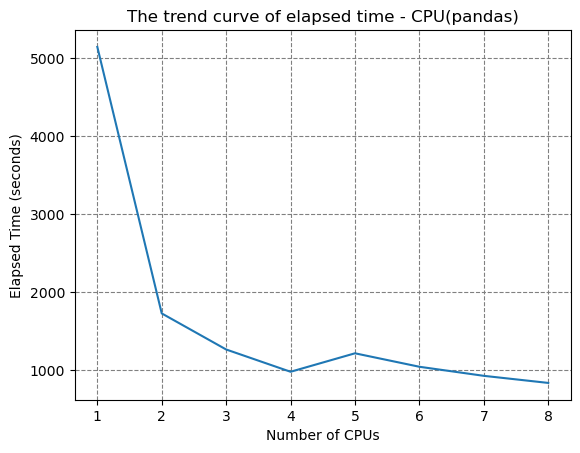

In [43]:
# Elapsed time - CPU(pandas)
time1 = 5147.88
time2 = 1725.51
time3 = 1262.30
time4 = 976.16
time5 = 1213.38
time6 = 1040.48
time7 = 923.97 
time8 = 832.95
plt.plot([1,2,3,4,5,6,7,8],[time1,time2,time3,time4,time5,time6,time7,time8])
plt.title("The trend curve of elapsed time - CPU(pandas)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of CPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

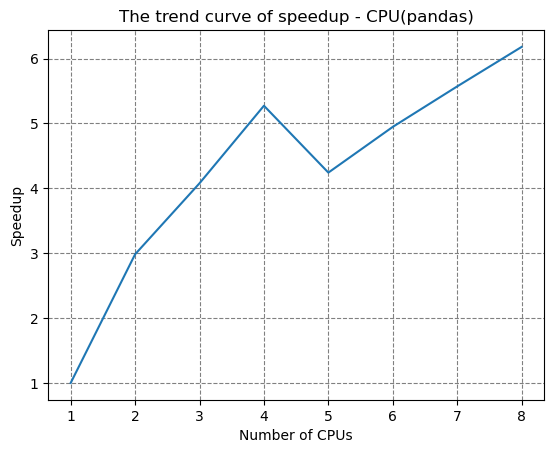

In [44]:
# Speedup - CPU(pandas)
speedup1 = time1/time1
speedup2 = time1/time2
speedup3 = time1/time3
speedup4 = time1/time4
speedup5 = time1/time5
speedup6 = time1/time6
speedup7 = time1/time7
speedup8 = time1/time8
plt.plot([1,2,3,4,5,6,7,8],[speedup1,speedup2,speedup3,speedup4,speedup5,speedup6,speedup7,speedup8])
plt.title("The trend curve of speedup - CPU(pandas)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

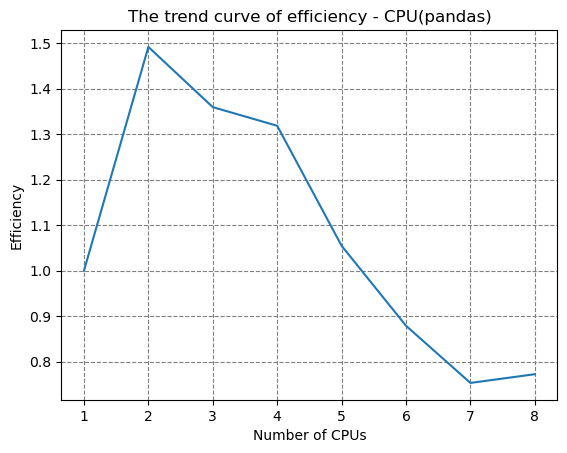

In [45]:
# Efficiency - CPU(pandas)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency3 = speedup3/3
efficiency4 = speedup4/4
efficiency5 = speedup4/5
efficiency6 = speedup4/6
efficiency7 = speedup4/7
efficiency8 = speedup8/8
plt.plot([1,2,3,4,5,6,7,8],[efficiency1,efficiency2,efficiency3,efficiency4,efficiency5,efficiency6,efficiency7,efficiency8])
plt.title("The trend curve of efficiency - CPU(pandas)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')

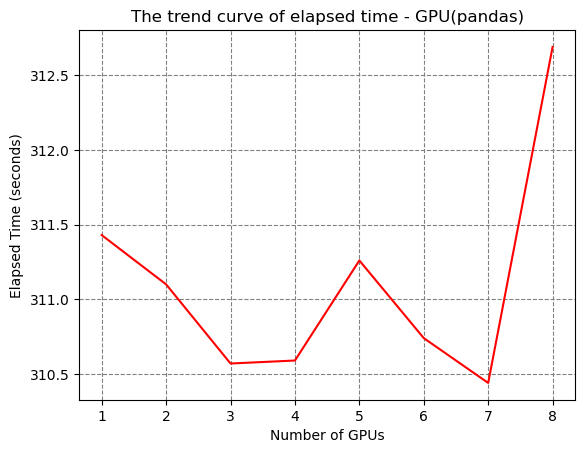

In [46]:
# Elapsed time - GPU(pandas)
time1 = 311.43
time2 = 311.10
time3 = 310.57 
time4 = 310.59
time5 = 311.26
time6 = 310.74
time7 = 310.44
time8 = 312.69
 
plt.plot([1,2,3,4,5,6,7,8],[time1,time2,time3,time4,time5,time6,time7,time8],color = 'red')
plt.title("The trend curve of elapsed time - GPU(pandas)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of GPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

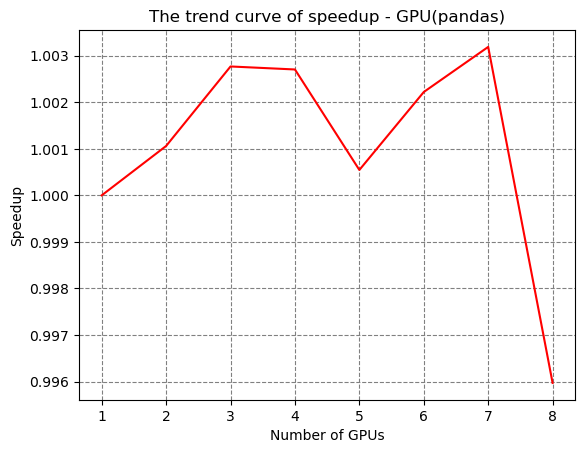

In [47]:
# Speedup - GPU(pandas)
speedup1 = time1/time1
speedup2 = time1/time2
speedup3 = time1/time3
speedup4 = time1/time4
speedup5 = time1/time5
speedup6 = time1/time6
speedup7 = time1/time7
speedup8 = time1/time8
plt.plot([1,2,3,4,5,6,7,8],[speedup1,speedup2,speedup3,speedup4,speedup5,speedup6,speedup7,speedup8],color = 'red')
plt.title("The trend curve of speedup - GPU(pandas)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

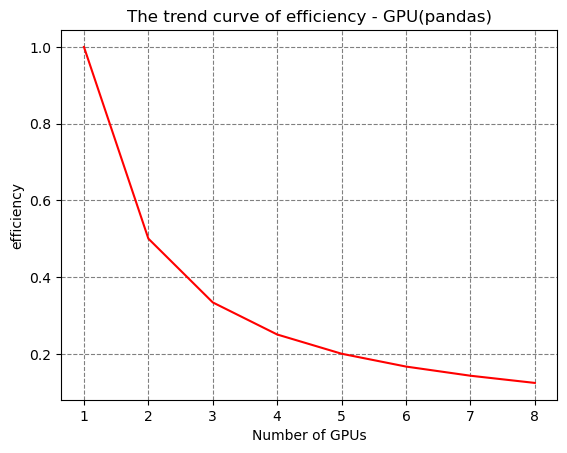

In [48]:
# Efficiency - GPU(pandas)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency3 = speedup3/3
efficiency4 = speedup4/4
efficiency5 = speedup4/5
efficiency6 = speedup4/6
efficiency7 = speedup4/7
efficiency8 = speedup8/8
plt.plot([1,2,3,4,5,6,7,8],[efficiency1,efficiency2,efficiency3,efficiency4,efficiency5,efficiency6,efficiency7,efficiency8],color = 'red')
plt.title("The trend curve of efficiency - GPU(pandas)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of GPUs')
plt.ylabel('efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')

## 2.2 Dask

### 2.2.1 Model evaluation metrics

In [49]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=200,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 1 CPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 1 CPU(Dask): 

accuracy  0.9809160770847751
precision 0.9654231036050409
recall    0.9975599661338093
f1        0.9812284714866801


In [50]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=25,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.6,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 2 CPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 2 CPU(Dask): 

accuracy  0.9810156139041527
precision 0.9658326640280545
recall    0.997312107163203
f1        0.9813199958191229


In [51]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.6,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 4 CPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 4 CPU(Dask): 

accuracy  0.9810140401994986
precision 0.9658297201118639
recall    0.997312107163203
f1        0.9813184762739461


In [52]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.8,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 8 CPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 8 CPU(Dask): 

accuracy  0.9810132533471715
precision 0.9658282481604984
recall    0.997312107163203
f1        0.9813177165031225


In [53]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.8,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 1 GPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 1 GPU(Dask): 

accuracy  0.9810124664948443
precision 0.9657295358482632
recall    0.9974199061440698
f1        0.9813189382350573


In [54]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=500,
                    min_child_weight=0,
                    max_delta_step=0,
                    subsample=0.95,
                    reg_alpha=0,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 2 GPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 2 GPU(Dask): 

accuracy  0.9810089256593724
precision 0.9657229141922463
recall    0.9974199061440698
f1        0.9813155196419096


In [55]:
# Remodel predictions using optimal parameters
from dask_ml.model_selection import train_test_split
X = over_balanced_data_dd.iloc[:,over_balanced_data_dd.columns !='isFraud'].values
y = over_balanced_data_dd.loc[:,'isFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X.compute_chunk_sizes(), y.compute_chunk_sizes(), test_size=0.2, random_state=0)
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=15,
                    learning_rate=0.05,
                    n_estimators=200,
                    min_child_weight=0,
                    max_delta_step=2,
                    subsample=0.95,
                    reg_alpha=1,
                )
clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)

# Output model evaluation metrics results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Evaluation of prediction results - 4 GPU(Dask):', '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Evaluation of prediction results - 4 GPU(Dask): 

accuracy  0.9809160770847751
precision 0.9654231036050409
recall    0.9975599661338093
f1        0.9812284714866801


### 2.2.2 Speedup and efficiency

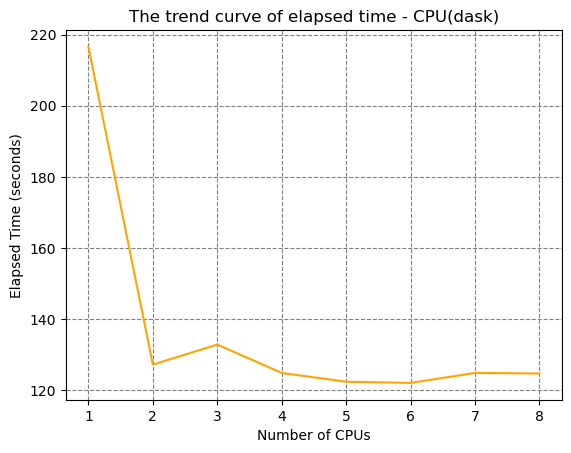

In [56]:
# Elapsed time - CPU(dask)
time1 = 216.55
time2 = 127.18
time3 = 132.81 
time4 = 124.83
time5 = 122.36
time6 = 122.02
time7 = 124.83
time8 = 124.67
 
plt.plot([1,2,3,4,5,6,7,8],[time1,time2,time3,time4,time5,time6,time7,time8],color = 'orange')
# plt.plot([1,2,4,8],[time1,time2,time4,time8],color = 'orange')
plt.title("The trend curve of elapsed time - CPU(dask)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of CPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

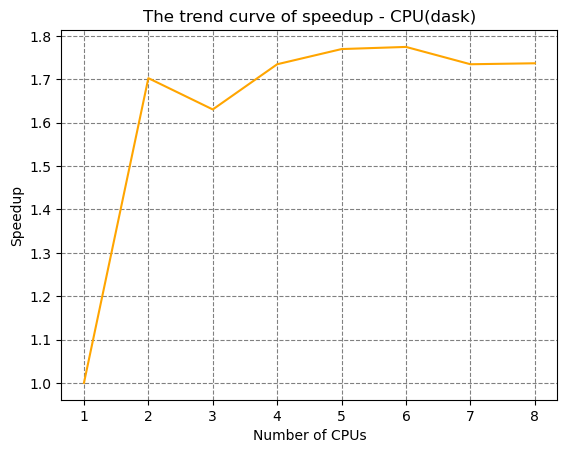

In [57]:
# Speedup - CPU(dask)
speedup1 = time1/time1
speedup2 = time1/time2
speedup3 = time1/time3
speedup4 = time1/time4
speedup5 = time1/time5
speedup6 = time1/time6
speedup7 = time1/time7
speedup8 = time1/time8
plt.plot([1,2,3,4,5,6,7,8],[speedup1,speedup2,speedup3,speedup4,speedup5,speedup6,speedup7,speedup8],color = 'orange')
plt.title("The trend curve of speedup - CPU(dask)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

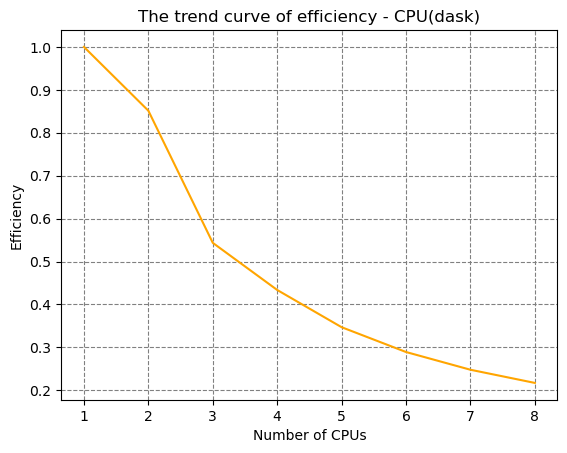

In [58]:
# Efficiency - CPU(dask)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency3 = speedup3/3
efficiency4 = speedup4/4
efficiency5 = speedup4/5
efficiency6 = speedup4/6
efficiency7 = speedup4/7
efficiency8 = speedup8/8
plt.plot([1,2,3,4,5,6,7,8],[efficiency1,efficiency2,efficiency3,efficiency4,efficiency5,efficiency6,efficiency7,efficiency8],color = 'orange')
# plt.plot([1,2,4,8],[efficiency1,efficiency2,efficiency4,efficiency8],color = 'orange')
plt.title("The trend curve of efficiency - CPU(dask)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')

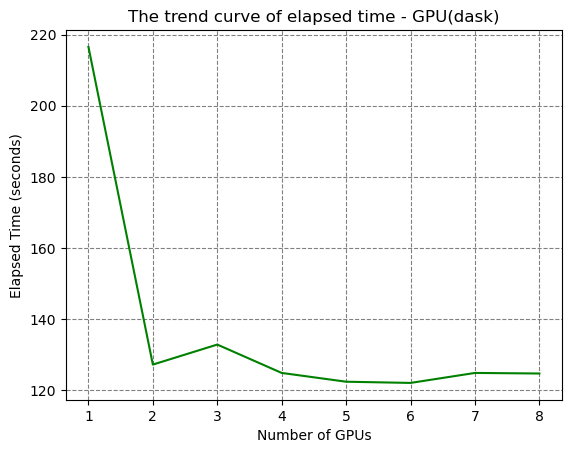

In [59]:
# Elapsed time - GPU(dask)
time1 = 216.55
time2 = 127.18
time3 = 132.81 
time4 = 124.83
time5 = 122.36
time6 = 122.02
time7 = 124.83
time8 = 124.67
 
plt.plot([1,2,3,4,5,6,7,8],[time1,time2,time3,time4,time5,time6,time7,time8],color = 'green')

plt.title("The trend curve of elapsed time - GPU(dask)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of GPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(color = 'grey', linestyle = 'dashed')

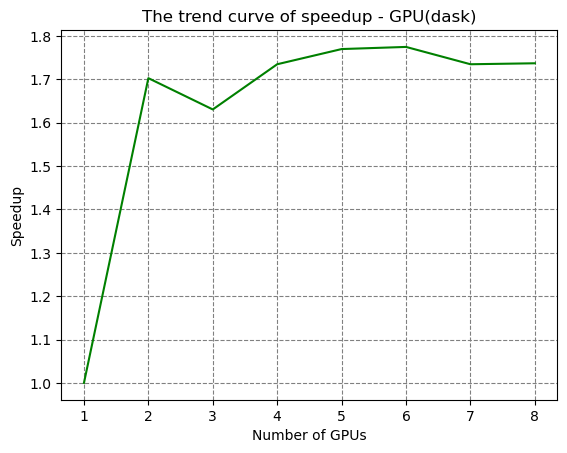

In [60]:
# Speedup - GPU(dask)
speedup1 = time1/time1
speedup2 = time1/time2
speedup3 = time1/time3
speedup4 = time1/time4
speedup5 = time1/time5
speedup6 = time1/time6
speedup7 = time1/time7
speedup8 = time1/time8
plt.plot([1,2,3,4,5,6,7,8],[speedup1,speedup2,speedup3,speedup4,speedup5,speedup6,speedup7,speedup8],color = 'green')
plt.title("The trend curve of speedup - GPU(dask)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of GPUs')
plt.ylabel('Speedup')
plt.grid(color = 'grey', linestyle = 'dashed')

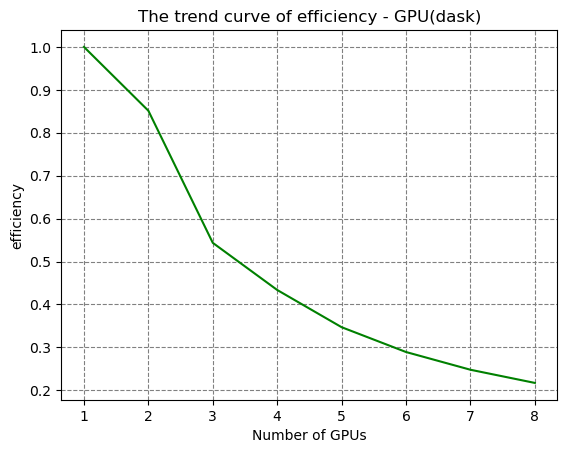

In [61]:
# Efficiency - GPU(dask)
efficiency1 = speedup1/1
efficiency2 = speedup2/2
efficiency3 = speedup3/3
efficiency4 = speedup4/4
efficiency5 = speedup4/5
efficiency6 = speedup4/6
efficiency7 = speedup4/7
efficiency8 = speedup8/8
plt.plot([1,2,3,4,5,6,7,8],[efficiency1,efficiency2,efficiency3,efficiency4,efficiency5,efficiency6,efficiency7,efficiency8],color = 'green')
plt.title("The trend curve of efficiency - GPU(dask)")
plt.xticks([1,2,3,4,5,6,7,8])
plt.xlabel('Number of GPUs')
plt.ylabel('efficiency')
plt.grid(color = 'grey', linestyle = 'dashed')